<a href="https://colab.research.google.com/github/friyk/DSL-30.110/blob/main/T02/T02_Basys3_StopWatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T02: Stopwatch on Basys 3

|Group members|Student ID|
|---|---|
|Chua Kevin Subong|1007002|
|Kaung Khant Htet|1003437|
|Ng Au Hern Wesley|1006888|
|Pan Ziyue|1006658|
|Shum Hei Lam|1009861|

## Objective:


Design and implement a **stopwatch** on the **Basys 3 FPGA** board using Verilog, making use of the **4-digit** **7-segment** display LEDs for time display. The stopwatch should have the following features:  
1. **Reset functionality**: Press a button (e.g., `btnR`) to restart the stopwatch.  
2. **Time Display**: Display the elapsed time in minutes and seconds on the 4-digit 7-segment display.  
3. **Update Frequency**: Update the display at a reasonable frequency (e.g., every 1 second).

## Instructions  

### FPGA Project  
1. Create a new Vivado project for the Basys 3 FPGA board.  
2. Write Verilog code to implement the stopwatch logic.  
3. Map the Verilog design to the Basys 3 board's resources via the basys3 [constraint file](./Demo_Code/basys3_template.xdc) (`.xdc`).   
4. Generate the bitstream file.
5. Program the FPGA board with the bitstream.  
6. Test and debug your stopwatch design on the FPGA board to ensure correct functionality.  
7. Document your design, including the Verilog code, functional diagrams, and challenges faced during implementation.  
8. **Demo Vivado Project**: [T02_Basys3_StopWatch](./Demo_Code/T02_Basys3_StopWatch)

## Simulation


- [Verify functionality using testbenches and waveform analysis.](Simulation/simT02_Basys3_StopWatch_SSD.ipynb)  




### Additional Challenge (*Optional*):

  
Add features like **pause/resume functionality** to the stopwatch design.  

## Submission:


*This is a group work. Only one member needs to submit the materials.*  
1. A self-contained `ipynb` file which:  
   - **Google Colab link** and **GitHub link**.  
   - **Verilog codes** (module, testbench, waveform, AI prompt, etc.).  
   - A **brief report** documenting the design, Python code (e.g., logic expressions, AI-generated code), challenges, and lessons learned;
2. A **demonstration video** (less than 1 minute, `.mp4` format).
* Submit to **edimension** and share with instructor GitHub: `pe8sutd`, `pe8sutd@gmail.com`.  
3. The report should report how AI is used in the design (if applicable). The guideline: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/pe8sutd/Colab_DSL_Practice25/blob/main/G01_Used_of_AI_in_Design.ipynb)


---

### Deadline:  
Refer to the due date in the **edimension submission folder**.  

---

### Grading:  
Based on:  
- Functionality of the stopwatch.  
- Clarity of Verilog code.  
- Quality of documentation.  
*Bonus points for additional features or creative implementations.*  

---



## Demo Video  


The following video below shows the stopwatch’s functionality on the Basys 3 board.

https://www.youtube.com/watch?v=eFecL3ZtbN0

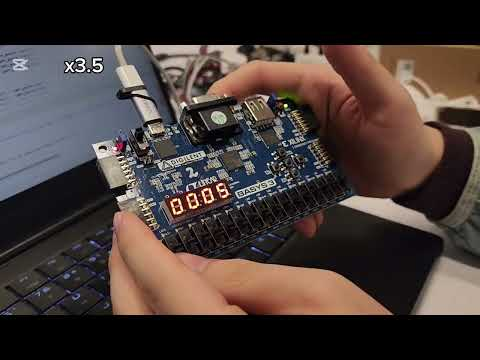

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('eFecL3ZtbN0')

## Design Report

Key features

- Reset button to restart the counter, but not start/stop it
- Start/Stop button to be able to resume/pause the timing.
- The timer counter itself is internally run at 1KHz, and is 32 bits wide, so 32'h00000001 is equivalent to 1 milisecond
- Time display module converts internal timer counter (miliseconds) into minutes and seconds for display

We have to develop the following modules for stopwatch to function correctly

- `debounce` Button conditioner: debounce button inputs
- `ssd` 7 Segment Driver: to drive the 7 segment display using BCD. This is already provided by lesson materials
- `clk_100M_to_1k` 100MHz to 1kHz Clock divider: to produce the 1ms period clock used to drive the internal stopwatch counter
- `tff` T-flip flop (TFF): to allow pausing the stopwatch by a single button press, connected to a multiplexor
- `ms_to_s` 32-bit ms to 16-bit seconds divider: this produces the raw number of seconds elapsed
- `s_to_mmss` 16-bit s to mm:ss divider: this produces the numerical outputs for minutes and seconds, which can then be encoded to BCD
- `min_to_bcd` 16-bit minutes to 2x4-bit BCD
- `sec_to_bcd` 16-bit seconds to 2x4-bit BCD

The inputs to our stopwatch is specified as follows:

- btnC: The centre button on the Basys 3 board, which starts/stops the stopwatch
- btcU: The up button on the Basys3 board, which resets the stopwatch

##Block Diagram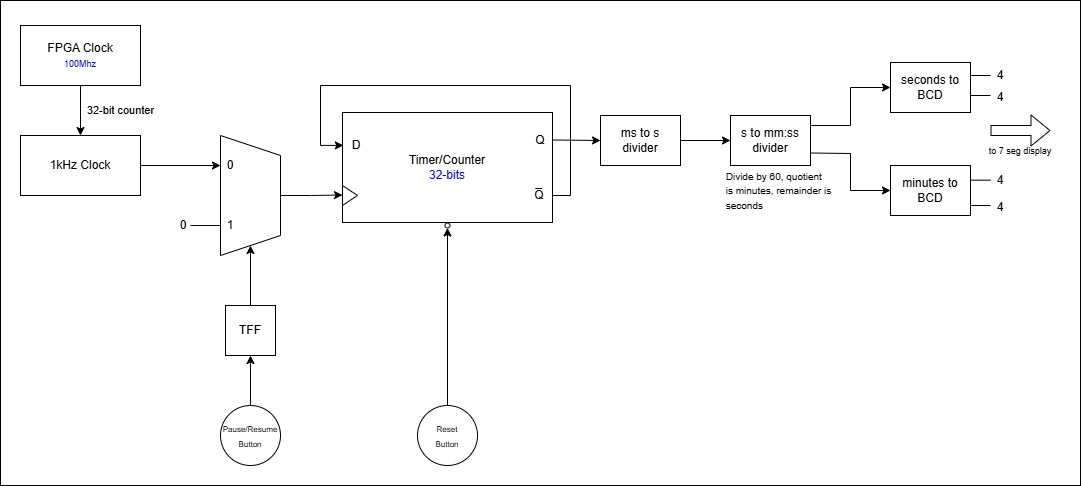

  ## **Verilog Code**


  ### top_module

In [ ]:
`timescale 1ns / 1ps

module top_module(
    input clk,          // 100MHz master clock
    input btnC,         // centre button, used for start/stop
    input btnU,         // up button, used for stopwatch reset
    input btnR,         // right button, used for master reset

    output [6:0]seg,    // 7 segment display
    output dp,          // 7 segment display decimal point
    output [3:0]an      // 7 segment anode
    );

    assign dp=1;

    // Debounced buttons
    wire startstop_btn, stopwatch_rst_btn;
    debounce(clk, btnR, btnC, startstop_btn);
    debounce(clk, btnR, btnU, stopwatch_rst_btn);

    // 500hz clock for driving the display
    wire clk500hz;
    clk_500hz(clk500hz, clk, stopwatch_rst_btn);

    // TFF to stop the clock
    wire clock_stopper_mux;
    tff(clk500hz, startstop_btn, clock_stopper_mux);

    // Master clock to 1kHz downconverter, and multiplexor to switch it
    wire clk1khz, clk1khz_switched;
    clk_100M_to_1k(clk, stopwatch_rst_btn, clk1khz);
    assign clk1khz_switched = clock_stopper_mux ? 0 : clk1khz;

    // Master miliseconds counter
    wire [31:0] miliseconds;
    ms_counter(stopwatch_rst_btn, clk1khz_switched, miliseconds);

    // Divide ms to s
    wire [15:0] seconds;
    ms_to_s(miliseconds, seconds);

    // Separate seconds into minutes and seconds
    wire [15:0] mm, ss;
    s_to_mmss(seconds, clk, mm, ss);

    // Convert mm and ss into BCD
    wire [3:0] minute_tens, minute_ones, second_tens, second_ones;
    min_to_bcd(mm, minute_ones, minute_tens);
    sec_to_bcd(ss, second_ones, second_tens);

    // Seven segment display
    ssd(~stopwatch_rst_btn, clk500hz, minute_tens, minute_ones, second_tens, second_ones, an, seg);

endmodule

###100Mhz to 1kHz Clock

In [ ]:
`timescale 1ns / 1ps

module clk_100M_to_1k(
    input clk_100M,     // Input clock from the FPGA's master clock
    input rst,          // Active high reset
    output reg clk_1k   // Output clock
    );

    reg [16:0] counter;

    initial clk_1k = 0;
    initial counter = 0;

    always @(posedge rst, posedge clk_100M) begin
        if (rst) begin
            counter <= 0;
            clk_1k <= 0;
        end
        else begin
            if (counter == 17'd50000) begin // For actual d100000/2=d50000, after this number of clock cycles the 1kHz clock transitions
//            if (counter == 17'd9) begin // For testbench purposes
                counter <= 0;
                clk_1k <= ~clk_1k;
            end else
                counter <= counter + 1;
        end
    end
endmodule

### Debounce module for button

To generate a single pulse with a period of the slow clock without bouncing

In [ ]:
`timescale 1ns / 1ps

module debounce (
    input wire clk,        // System clock (e.g., 100 MHz on Basys 3)
    input wire reset,      // Reset signal
    input wire button_in,  // Raw button input
    output reg button_out  // Debounced button output
);

    reg [19:0] count;      // 20-bit counter for debouncing
    reg button_prev;        // Previous state of the button

    always @(posedge clk or posedge reset) begin
        // Reset counter and button statuses if reset pin asserted
        if (reset) begin
            count <= 20'b0;
            button_prev <= 1'b0;
            button_out <= 1'b0;
        end else begin
            button_prev <= button_in;
            // Set counter to 0 when button state changes
            if (button_prev != button_in) begin
                count <= 20'b0;
            // If counter hits maximum, set button output to previous button state
            end else if (count == 20'h0000F) begin
                button_out <= button_prev;
            // Increment counter
            end else begin
                count <= count + 1;
            end
        end
    end

endmodule

### T Flip Flop

used to intercept an already debounced button press and toggle a state between 0 and 1. Effectively a D flip flop with inverted output shorted to input

In [ ]:
`timescale 1ns / 1ps

module tff(
    input clk,
    input t,
    output reg q
    );

    initial q = 0;

    always @ (posedge clk) begin
        q <= (t ? ~q : q);
    end

endmodule

### Milliseconds Counter

In [ ]:
`timescale 1ns / 1ps

module ms_counter(
    input rst,
    input clk,
    output reg [31:0] out
    );

    initial out = 0;

    // Synchronous reset
    always @(posedge clk or posedge rst) begin
        if (rst)
            out <= 0;
        else
            out <= out + 1;
    end

endmodule

### Milliseconds to seconds

In [ ]:
`timescale 1ns / 1ps

// Refer to this link https://web.archive.org/web/20180517023231/http://www.hackersdelight.org/divcMore.pdf
// For how to do a divide by 1000! Although it's in C, it avoids using any complex operations like multiply and divide

module ms_to_s(
    input [32:0]ms,
    output [15:0]s
    );

    assign s = ms / 1000;

endmodule

### Seconds to minutes and seconds (mm:ss)

In [ ]:
`timescale 1ns / 1ps

module s_to_mmss(
    input [15:0] s,
    input clk,          // This device relies on the master 100MHz clock to perform simple division
    output reg [15:0] mm,
    output reg [15:0] ss
    );

//    assign mm = s / 60;
//    assign ss = s % 60;

    // We use simple primary school style division, keep subtracting until we cannot subtract anymore and we get our quotient and remainder :)

    reg [2:0]state;
    reg signed [16:0]quotient;
    reg signed [16:0]remainder;
    reg signed [16:0]temp;

    initial quotient = 0;
    initial remainder = 0;
    initial state = 0;
    initial temp = 0;
    initial mm = 0;
    initial ss = 0;


    always @(posedge clk) begin
        // Load from inputs
        if (state == 0) begin
            // Load seconds into the temp register
            temp <= s;

            // Reset quotient and remainders
            quotient <= 0;
            remainder <= 0;

            // Preserve output register values
            mm <= mm;
            ss <= ss;

            // Transition to state 0 (calculating state 1)
            state <= 1;
        end

        else if (state == 1) begin
            // Save temp to register, before trying to calculate quotient
            remainder <= temp;

            state <= 2;
        end

        else if (state == 2) begin
            temp <= temp - 60; // Perform division by subtracting 60 repeatedly

            state <= 3;
        end

        else if (state == 3) begin
            if (temp < 0) begin
                // Ignore the result, we've reached minimum, preserve quotient and save results to output regs
                quotient <= quotient;
                remainder <= remainder;
                state <= 4;
            end else begin
                // Continue subtracting
                quotient <= quotient + 1;
                remainder <= remainder;
                state <= 1;
            end
        end

        // Save data, and go back to the beginning
        else begin
            mm <= quotient;
            ss <= remainder;

            state <= 0;
        end

    end

endmodule

### Seconds to BCD

In [ ]:
`timescale 1ns / 1ps

module sec_to_bcd(
    input  [15:0] ss,       // seconds (0–59)
    output [3:0] bcd_0,     // Ones place (0–9)
    output [3:0] bcd_1      // Tens place (0–5)
);

    assign bcd_1 = ss / 10;   // Tens digit
    assign bcd_0 = ss % 10;   // Ones digit

endmodule

###Minutes to BCD

In [ ]:
`timescale 1ns / 1ps

module min_to_bcd(
    input  [15:0] mm,
    output [3:0] bcd_0,
    output [3:0] bcd_1
);

    assign bcd_0 = mm % 10;    // Ones place
    assign bcd_1 = mm / 10;    // Tens place

endmodule

### Seven segment display

In [ ]:
`timescale 1ns / 1ps

module ssd(
    input           rstn_i,
    input           clk_500hz,
    input   [3:0]   num3_i,
    input   [3:0]   num2_i,
    input   [3:0]   num1_i,
    input   [3:0]   num0_i,
    output  [3:0]   an_o,
    output  [7:0]   seg_o
);

reg [7:0] segment_r;
reg [3:0] cur_num_r;
reg [3:0] an_r;

initial an_r = 0;
initial segment_r = 0;

assign an_o = ~an_r;       // Anode outputs are inverted
assign seg_o = segment_r;  // Segment outputs are not inverted

// Anode rotation logic, upon every CLK the anode has to be rotated to the next digit
always @(negedge rstn_i, posedge clk_500hz) begin
    if (!rstn_i) an_r <= 4'b0000;
    else case (an_r)
        4'b0001: an_r <= 4'b0010;  // DIG3
        4'b0010: an_r <= 4'b0100;  // DIG2
        4'b0100: an_r <= 4'b1000;  // DIG1
        default: an_r <= 4'b0001;  // DIG4 (including reset state)
    endcase
end

// Mux to wire up the correct digit segments based on the current anode
always @(*) begin
    case (an_r)
        4'b0001: cur_num_r = num0_i;  // DIG4 (LSB)
        4'b0010: cur_num_r = num1_i;  // DIG3
        4'b0100: cur_num_r = num2_i;  // DIG2
        4'b1000: cur_num_r = num3_i;  // DIG1 (MSB)
        default: cur_num_r = 4'b0;    // All off
    endcase
end

// Decode number into 7-segment codes
always @(*) begin
    case (cur_num_r)
        4'h0: segment_r = 8'hC0;  // 0
        4'h1: segment_r = 8'hF9;  // 1
        4'h2: segment_r = 8'hA4;  // 2
        4'h3: segment_r = 8'hB0;  // 3
        4'h4: segment_r = 8'h99;  // 4
        4'h5: segment_r = 8'h92;  // 5
        4'h6: segment_r = 8'h82;  // 6
        4'h7: segment_r = 8'hF8;  // 7
        4'h8: segment_r = 8'h80;  // 8
        4'h9: segment_r = 8'h90;  // 9
        default: segment_r = 8'hFF; // Off
    endcase
end

endmodule


// Provides a 500Hz resettable clock from the 100MHz system clock by decimal division
module clk_500hz(
    output reg clk_out,
    input clk_in, reset
);
    reg[17:0]count;

    always@(posedge clk_in) begin
        if (reset)
            count <= 18'h000000;
        else if (count==18'h30D40) begin
            clk_out <= 1'b1; count <= 18'h000000;
        end else begin
            count <= count + 1'b1;
            clk_out <=1'b0;
        end
    end
endmodule